## Elements of Statistical Learning (ESL) Final Project

**Our Machine Learning Question:**

**How can we improve the accuracy of predicting** which diabetic patients are likely to be readmitted to the hospital within 30 days across different classifiers **by addressing the severe class imbalance in the dataset?**
The dataset we chose is on “Early Readmission Prediction of Patients Diagnosed with Diabetes,” which has a significant class imbalance between early admitted patients and others. The positive class for our classification (early admitted patients) is underrepresented with a ratio of 1-to-9.

The techniques we are considering implementing to overcome the class imbalance in the dataset are as follows:
1. SMOTE (Synthetic Minority Oversampling Technique)
2. Class weights
3. Ensemble methods

All the above techniques will be compared across different classifiers to answer the following question: How well do different models (e.g., Logistic Regression, Random Forest, SVM) handle the imbalance and predict early readmissions?

Recommendations from Professor David:

- Check how different models react to class imbalance prior to implementing balancing techniques.
- Also, check if the balancing techniques actually cause that the same objects are misclassified, or that suddenly also other objects go wrong (that used to be classified well).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data Loading and Exploration

The chosen dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days.

Link to the dataset: https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008

**Our Aim:** Identifying patients at risk of being readmitted within 30 days of discharge.

In [2]:
dataset = pd.read_csv('diabetic_data.csv')

# Explore the first rows of the dataset
dataset.head(20)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
# Also explore the last rows of the dataset
dataset.tail(20)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101746,443797298,89955270,Caucasian,Male,[70-80),?,1,1,7,4,...,No,No,No,No,No,No,No,No,Yes,<30
101747,443804570,33230016,Caucasian,Female,[70-80),?,1,22,7,8,...,No,Steady,No,No,No,No,No,No,Yes,>30
101748,443811536,189481478,Caucasian,Female,[40-50),?,1,4,7,14,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101749,443816024,106392411,Caucasian,Female,[70-80),?,3,6,1,3,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
101750,443824292,138784172,Caucasian,Female,[80-90),?,3,1,1,3,...,No,Down,No,No,No,No,No,Ch,Yes,<30
101751,443835140,175326800,Caucasian,Male,[70-80),?,3,6,1,13,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101752,443835512,139605341,Other,Female,[40-50),?,3,1,1,3,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
101753,443841992,184875899,Other,Male,[40-50),?,1,1,7,13,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101754,443842016,183087545,Caucasian,Female,[70-80),?,1,1,7,9,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
101755,443842022,188574944,Other,Female,[40-50),?,1,1,7,14,...,No,Up,No,No,No,No,No,Ch,Yes,>30


In [4]:
print("Overview of the dataset displaying non-null values and data types:")
print(dataset.info())

Overview of the dataset displaying non-null values and data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int6

In [5]:
print("Shape of the dataset:", dataset.shape)
print(dataset.columns)

Shape of the dataset: (101766, 50)
Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


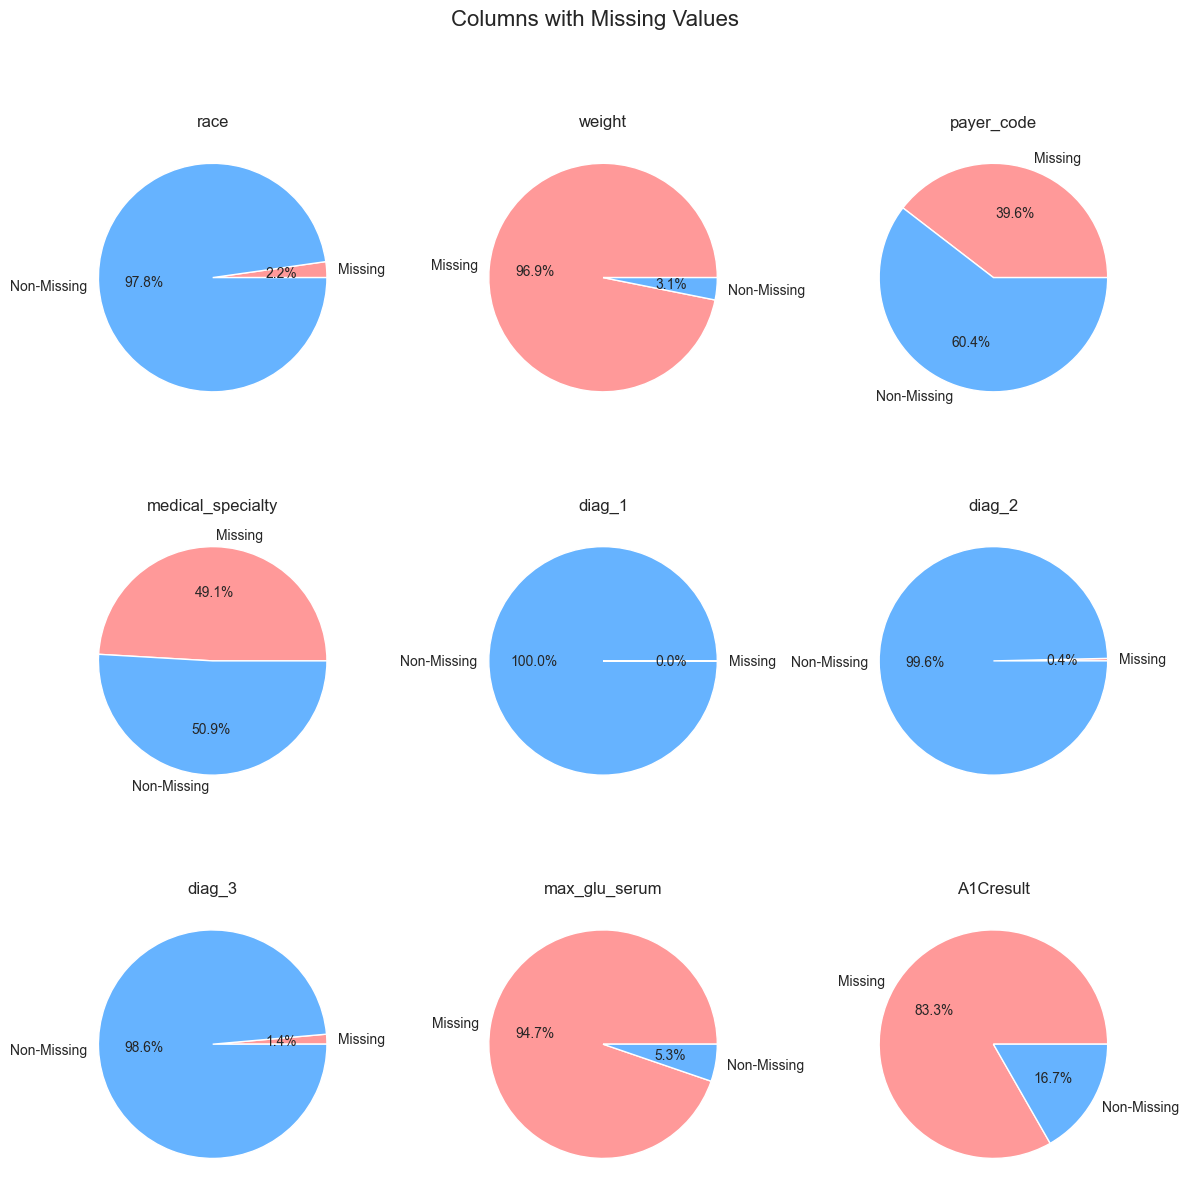

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Visualize columns that contain missing values with pie-charts
dataset_visualization = dataset.copy()
dataset_visualization.replace('?', np.nan, inplace=True)
columns_with_missing = dataset_visualization.columns[dataset_visualization.isnull().any()]

num_columns = len(columns_with_missing)

per_row = 3  
rows = (num_columns // per_row) + (num_columns % per_row > 0)
fig, axes = plt.subplots(rows, per_row, figsize=(per_row * 4, rows * 4))
axes = axes.flatten()

for i, col in enumerate(columns_with_missing):
    missing_count = dataset_visualization[col].isnull().sum()
    non_missing_count = dataset_visualization[col].notnull().sum()
    
    data = [missing_count, non_missing_count]
    labels = ['Missing', 'Non-Missing']
    colors = ['#ff9999', '#66b3ff']

    axes[i].pie(data, labels=labels, autopct='%1.1f%%', colors=colors)
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Columns with Missing Values", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [7]:
target_distribution = dataset['readmitted'].value_counts()

print("Distribution of 'readmitted' target column:")
print(target_distribution)

target_percentage = dataset['readmitted'].value_counts(normalize=True) * 100
print("\nPercentage distribution of 'readmitted' target column:")
print(f"{round(target_percentage, 2)}")

Distribution of 'readmitted' target column:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

Percentage distribution of 'readmitted' target column:
readmitted
NO     53.91
>30    34.93
<30    11.16
Name: proportion, dtype: float64


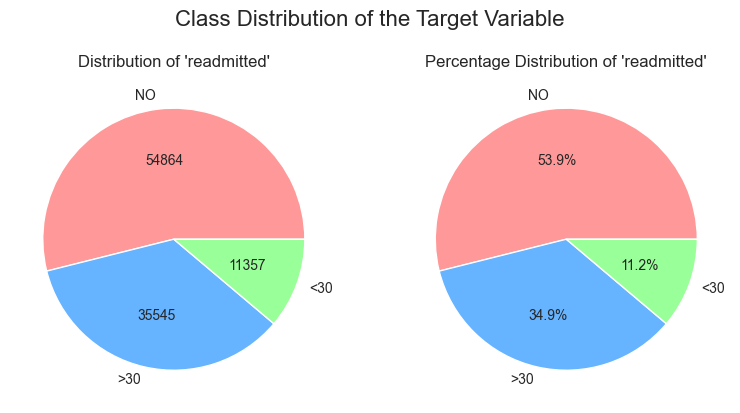

In [8]:
# Visualizing the imbalance in the dataset

per_row = 2
rows = 1
fig, axes = plt.subplots(rows, per_row, figsize=(per_row * 4, rows * 4))
axes = axes.flatten()

data_counts = target_distribution
data = target_distribution
labels = target_distribution.index 
colors = ['#ff9999', '#66b3ff', '#99ff99']

axes[0].pie(data, labels=labels, autopct=lambda p: f'{int(p * sum(data_counts) / 100)}', colors=colors)
axes[0].set_title("Distribution of 'readmitted'")

data = target_percentage

axes[1].pie(data, labels=labels, autopct='%1.1f%%', colors=colors)
axes[1].set_title("Percentage Distribution of 'readmitted'")

plt.suptitle("Class Distribution of the Target Variable", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Binary Classification Formulation

There are three classes in the target 'readmitted' column:
- Class 1: <30 (early admission)
- Class 2: NO (no admission)
- Class 3: >30 (late admission)

For the purpose of our early admission prediction problem, we will use binary classification because we are looking for a way to classify early admissions correctly in this problem. Therefore, for our problem, the "No" and ">30" cases mean the same and can be combined into the same group.

Hence, the **binary classification** formulation can be described as follows:
- Class 1: <30 (early admission)
- Class 2: NO and >30 (no admission and late admission)

### Understanding the Imbalance in the Dataset

After formulating the dataset as a binary classification problem, it can be seen that the combined percentage of the "No" and ">30" classes is approximately 88.84%, whereas the percentage distribution of the early admission class "<30" is 11.16%.

Hence, it can be seen that there is a severe imbalance in the dataset. The positive class for our classification (early admitted patients) is underrepresented, with a ratio of 1-to-9.

### Setting up the Dataset

- Merge the ">30" and "NO" categories of the target variable
- Split the dataset into training and test sets first, ensuring that all preprocessing steps are based on the training data. This will prevent **data leakage**. In other words, information from the test set will not influence the model during training.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Merging ">30" and "NO" (not readmitted) categories of the target variable
dataset['readmitted'] = dataset['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

dataset.head(20)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,0
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,0
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,0
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,0
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,0
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,0
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [10]:
target_distribution = dataset['readmitted'].value_counts()

print("Distribution of 'readmitted' target column:")
print(target_distribution)

target_percentage = dataset['readmitted'].value_counts(normalize=True) * 100
print("\nPercentage distribution of 'readmitted' target column:")
print(f"{round(target_percentage, 2)}")

Distribution of 'readmitted' target column:
readmitted
0    90409
1    11357
Name: count, dtype: int64

Percentage distribution of 'readmitted' target column:
readmitted
0    88.84
1    11.16
Name: proportion, dtype: float64


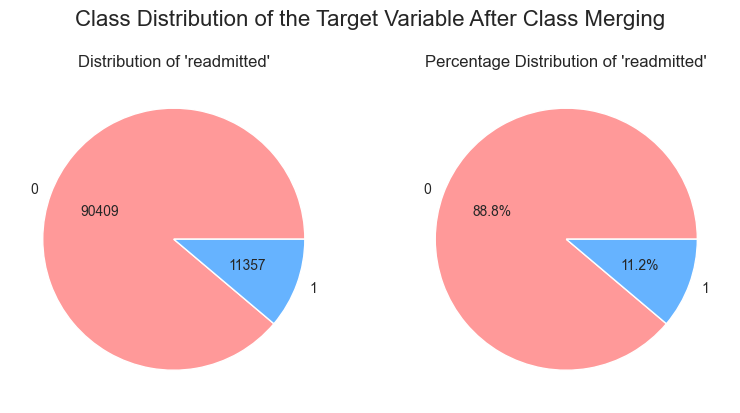

In [11]:
# Visualizing the imbalance in the dataset

per_row = 2
rows = 1
fig, axes = plt.subplots(rows, per_row, figsize=(per_row * 4, rows * 4))
axes = axes.flatten()

data_counts = target_distribution
data = target_distribution
labels = target_distribution.index 
colors = ['#ff9999', '#66b3ff', '#99ff99']

axes[0].pie(data, labels=labels, autopct=lambda p: f'{int(p * sum(data_counts) / 100)}', colors=colors)
axes[0].set_title("Distribution of 'readmitted'")

data = target_percentage

axes[1].pie(data, labels=labels, autopct='%1.1f%%', colors=colors)
axes[1].set_title("Percentage Distribution of 'readmitted'")

plt.suptitle("Class Distribution of the Target Variable After Class Merging", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Grouping

To prevent data leakage, that is information of the same patient being separated in training and test sets

In [12]:
# dataframe of patient_nbr and num_readmissions (if size > 1, the patients came back within 30 days)
df_patient = dataset.groupby(['patient_nbr']).size().reset_index(name='num_readmissions')

# patients' number (id), that we were and weren't readmitted within 30 days
df_readmitted = df_patient[df_patient['num_readmissions'] > 1]

temp = df_patient.merge(df_readmitted, on=['patient_nbr'], how='left', indicator=True)
df_not_readmitted = temp[temp['num_readmissions_y'].isna()]

df_not_readmitted = df_not_readmitted.drop(columns=['num_readmissions_x', 'num_readmissions_y', '_merge'], axis=1)
df_readmitted = df_readmitted.drop('num_readmissions', axis=1)

print("Number of patient without early readmission:", df_not_readmitted.count()) # 54745
print("Number of patient with early readmission:", df_readmitted.count()) # 16773

Number of patient without early readmission: patient_nbr    54745
dtype: int64
Number of patient with early readmission: patient_nbr    16773
dtype: int64


### Stratification

To ensure the same proportion of patients of each target class in the training and testing datasets:
- Training set: 80% of all not readmitted patients and 80% of all readmitted patients
- Testing set: 20% of all not readmitted patients and 20% of all readmitted patients

In [13]:
def stratified_split(df):
    df = df.sort_values(['patient_nbr'], ascending=True)
    count_row = int(round(df.shape[0] * .8, 0))
    # print(count_row)
    df_80 = df.head(count_row)
    # print(df_80)

    df_20 = pd.merge(df, df_80, how='left', indicator=True)
    df_20 = df_20[df_20['_merge'] == 'left_only']
    df_20 = df_20.drop(columns=['_merge'])
    # print(df_20)

    common_rows = pd.merge(df_20, df_80, how='inner')
    if common_rows.empty:
        print("df_20 and df_80 have no rows in common.")
    else:
        print("There are common rows between df_20 and df_80.")

    df_combined = pd.concat([df_20, df_80])
    if df_combined.sort_values(by=df.columns.tolist()).reset_index(drop=True).equals(
            df.sort_values(by=df.columns.tolist()).reset_index(drop=True)):
        print("df_20 and df_80 together form df.")
    else:
        print("df_20 and df_80 do not form df.")

    return df_80, df_20

In [14]:
df_not_readmitted_80, df_not_readmitted_20 = stratified_split(df_not_readmitted)
df_readmitted_80, df_readmitted_20 = stratified_split(df_readmitted)
train_dataset_patients = pd.concat([df_not_readmitted_80, df_readmitted_80])
train_dataset = pd.merge(train_dataset_patients, dataset, how='inner', on='patient_nbr')

if train_dataset['patient_nbr'].nunique() == train_dataset_patients['patient_nbr'].nunique():
    print("The train dataset contains the correct number of unique patients.")
else:
    print(f"Mismatch in train dataset: Expected {train_dataset_patients['patient_nbr'].nunique()} unique patients, "
          f"but got {train_dataset['patient_nbr'].nunique()}.")

test_dataset_patients = pd.concat([df_not_readmitted_20, df_readmitted_20])
test_dataset = pd.merge(test_dataset_patients, dataset, how='inner', on='patient_nbr')

if test_dataset['patient_nbr'].nunique() == test_dataset_patients['patient_nbr'].nunique():
    print("The test dataset contains the correct number of unique patients.")
else:
    print(f"Mismatch in test dataset: Expected {test_dataset_patients['patient_nbr'].nunique()} unique patients, "
          f"but got {test_dataset['patient_nbr'].nunique()}.")

print("Training dataset")
print(train_dataset)
print("Testing dataset")
print(test_dataset)

df_20 and df_80 have no rows in common.
df_20 and df_80 together form df.
df_20 and df_80 have no rows in common.
df_20 and df_80 together form df.
The train dataset contains the correct number of unique patients.
The test dataset contains the correct number of unique patients.
Training dataset
       patient_nbr  encounter_id             race  gender      age weight  \
0              378      29758806        Caucasian  Female  [50-60)      ?   
1              729     189899286        Caucasian  Female  [80-90)      ?   
2              774      64331490        Caucasian  Female  [80-90)      ?   
3              927      14824206  AfricanAmerican  Female  [30-40)      ?   
4             1305      66197028        Caucasian  Female  [60-70)      ?   
...            ...           ...              ...     ...      ...    ...   
81432     90583002     172050156        Caucasian    Male  [80-90)      ?   
81433     90583965      63799866        Caucasian    Male  [30-40)      ?   
81434     9

#### Data Splitting

In [15]:
X_train = train_dataset.drop(columns=['readmitted'])
y_train = train_dataset['readmitted']

X_test = test_dataset.drop(columns=['readmitted'])
y_test = test_dataset['readmitted']

# dropping id columns
dataset = dataset.drop(columns=['encounter_id', 'patient_nbr'], axis=1)
X_train = X_train.drop(columns=['encounter_id', 'patient_nbr'], axis=1)
X_test = X_test.drop(columns=['encounter_id', 'patient_nbr'], axis=1)

data = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1) # Training dataset
test_data = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1) # Test dataset

print("Shape of the original dataset:", dataset.shape)
print("Shape of the training dataset (data):", data.shape)
print("Shape of the test dataset (test_data):", test_data.shape)

Shape of the original dataset: (101766, 48)
Shape of the training dataset (data): (81437, 48)
Shape of the test dataset (test_data): (20329, 48)


### Missing Value Handling

In [16]:
missing_values = data.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]
print(f"Columns with missing values:\n{columns_with_missing_values}")

Columns with missing values:
max_glu_serum    76493
A1Cresult        68206
dtype: int64


It is observed from the dataset that in some columns, missing values are represented by the '?' character. Hence, a second data exploration step for analyzing which columns contain the question mark character and their counts is conducted.

In [17]:
question_marks = (data == '?').sum()
columns_with_question_marks = question_marks[question_marks > 0]
print(f"Columns containing question marks and their counts:\n{columns_with_question_marks}")

Columns containing question marks and their counts:
race                  1961
weight               79161
payer_code           34769
medical_specialty    39918
diag_1                  19
diag_2                 335
diag_3                1290
dtype: int64


Based on this observation, we decided to find the summation of missing values (both NaN and ? characters).

In [18]:
total_missing_values = missing_values + question_marks
columns_with_all_missing_values = total_missing_values[total_missing_values > 0]
print("Columns with missing values (including '?' and NaN):")
print(columns_with_all_missing_values)

Columns with missing values (including '?' and NaN):
race                  1961
weight               79161
payer_code           34769
medical_specialty    39918
diag_1                  19
diag_2                 335
diag_3                1290
max_glu_serum        76493
A1Cresult            68206
dtype: int64


In [19]:
# Convert '?'s into pandas NA values
data = data.replace('?', pd.NA)
test_data = test_data.replace('?', pd.NA)

# Check to see if the missing value summations match with the previous cell's output
missing_values = data.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]
print(f"Columns with missing values:\n{columns_with_missing_values}")

assert (total_missing_values == missing_values).all(), "Mismatch in missing value summations!"

# If the assertion is successful, print a success message
print("\nConsistency check passed: Missing value summations match for '?' and NaN handling.")

Columns with missing values:
race                  1961
weight               79161
payer_code           34769
medical_specialty    39918
diag_1                  19
diag_2                 335
diag_3                1290
max_glu_serum        76493
A1Cresult            68206
dtype: int64

Consistency check passed: Missing value summations match for '?' and NaN handling.


#### Baseline Approach: Deleting the Rows with Missing Values

Remove rows that contain at least one missing value in any column.

In [20]:
data_dropped = data.dropna()
print(f"Original dataset shape: {data.shape}")
print(f"Cleaned dataset shape after dropping rows: {data_dropped.shape}")

Original dataset shape: (81437, 48)
Cleaned dataset shape after dropping rows: (0, 48)


It is observed from the output of the previous cell that no rows remain in the dataset when we drop the rows containing a missing value. This suggests that each row contains at least one missing value.

Hence, a more sophisticated missing-value handling is needed.

Firstly, the following three columns contain between approximately 83% - 97% missing values:
- weight               (78916 missing values out of 81412)
- max_glu_serum        (77130 missing values out of 81412)
- A1Cresult            (67793 missing values out of 81412)

Hence, they are not informative and can be dropped before continuing with the rest of the analysis.


In [21]:
print(f"Original training dataset shape: {data.shape}")
columns_to_drop = ['weight', 'max_glu_serum', 'A1Cresult']
data = data.drop(columns=columns_to_drop, axis=1)
print(f"Training dataset shape after dropping columns: {data.shape}")

# Drop the same columns from the test data as well
print(f"Original test dataset shape: {test_data.shape}")
test_data = test_data.drop(columns=columns_to_drop, axis=1)
print(f"Test dataset shape after dropping columns: {test_data.shape}")

# Drop the same columns from the test data as well
print(f"Entire dataset shape: {dataset.shape}")
dataset = dataset.drop(columns=columns_to_drop, axis=1)
print(f"Entire dataset shape after dropping columns: {dataset.shape}")

Original training dataset shape: (81437, 48)
Training dataset shape after dropping columns: (81437, 45)
Original test dataset shape: (20329, 48)
Test dataset shape after dropping columns: (20329, 45)
Entire dataset shape: (101766, 48)
Entire dataset shape after dropping columns: (101766, 45)


NOTE: The two columns that contain approximately 50% missing values can also be dropped. Discuss it with your teammates.

- payer_code           (32157 missing values out of 81412)
- medical_specialty    (40057 missing values out of 81412)

In [22]:
# Now, again remove rows that contain at least one missing value in any column.
print(f"Dataset shape before dropping rows: {data.shape}")
data_dropped = data.dropna()
print(f"Cleaned dataset shape after dropping rows: {data_dropped.shape}")

Dataset shape before dropping rows: (81437, 45)
Cleaned dataset shape after dropping rows: (19550, 45)


**Observation**

Since a significant amount (three-forths) of all entries have been deleted, *Deleting the Rows with Missing Values* is not the most reasonable approach but it'll serve as a baseline for the filling of missing values.

#### Correlation-based Imputation

Identify which features are highly correlated and impute missing values accordingly.

In [23]:
print("Column types before applying mapping:")
print(data.dtypes[:25])

Column types before applying mapping:
race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
dtype: object


In [24]:
print("Column types before applying mapping:")
print(data.dtypes[25:])

# First, apply mapping to non-numeric columns,
# prior to computing the correlation between the features

data_encoded = data.copy()
for column in data.select_dtypes(include=['object', 'category']).columns:
    data_encoded[column] = data_encoded[column].astype('category').cat.codes

Column types before applying mapping:
glipizide                   object
glyburide                   object
tolbutamide                 object
pioglitazone                object
rosiglitazone               object
acarbose                    object
miglitol                    object
troglitazone                object
tolazamide                  object
examide                     object
citoglipton                 object
insulin                     object
glyburide-metformin         object
glipizide-metformin         object
glimepiride-pioglitazone    object
metformin-rosiglitazone     object
metformin-pioglitazone      object
change                      object
diabetesMed                 object
readmitted                   int64
dtype: object


In [25]:
print("Column types after applying mapping:")
print(data_encoded.dtypes[:25])

Column types after applying mapping:
race                         int8
gender                       int8
age                          int8
admission_type_id           int64
discharge_disposition_id    int64
admission_source_id         int64
time_in_hospital            int64
payer_code                   int8
medical_specialty            int8
num_lab_procedures          int64
num_procedures              int64
num_medications             int64
number_outpatient           int64
number_emergency            int64
number_inpatient            int64
diag_1                      int16
diag_2                      int16
diag_3                      int16
number_diagnoses            int64
metformin                    int8
repaglinide                  int8
nateglinide                  int8
chlorpropamide               int8
glimepiride                  int8
acetohexamide                int8
dtype: object


In [26]:
print("Column types after applying mapping:")
print(data_encoded.dtypes[25:])

Column types after applying mapping:
glipizide                    int8
glyburide                    int8
tolbutamide                  int8
pioglitazone                 int8
rosiglitazone                int8
acarbose                     int8
miglitol                     int8
troglitazone                 int8
tolazamide                   int8
examide                      int8
citoglipton                  int8
insulin                      int8
glyburide-metformin          int8
glipizide-metformin          int8
glimepiride-pioglitazone     int8
metformin-rosiglitazone      int8
metformin-pioglitazone       int8
change                       int8
diabetesMed                  int8
readmitted                  int64
dtype: object


In [27]:
# Check the first 5 rows of the mapped data to see the encodings
print(data_encoded.head)

<bound method NDFrame.head of        race  gender  age  admission_type_id  discharge_disposition_id  \
0         2       0    5                  3                         1   
1         2       0    8                  1                         3   
2         2       0    8                  1                         1   
3         0       0    3                  1                         1   
4         2       0    6                  3                         1   
...     ...     ...  ...                ...                       ...   
81432     2       1    8                  1                         3   
81433     2       1    3                  2                         1   
81434     2       1    3                  1                         1   
81435     0       0    6                  1                         1   
81436     0       0    6                  1                         1   

       admission_source_id  time_in_hospital  payer_code  medical_specialty  \
0             

In [28]:
# Now, compute the correlation matrix using the encoded data

correlation_matrix = data_encoded.corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                              race    gender       age  admission_type_id  \
race                      1.000000  0.058165  0.116392           0.110893   
gender                    0.058165  1.000000 -0.041813           0.017514   
age                       0.116392 -0.041813  1.000000          -0.006832   
admission_type_id         0.110893  0.017514 -0.006832           1.000000   
discharge_disposition_id  0.015661 -0.017595  0.111464           0.102419   
admission_source_id       0.037504 -0.004770  0.051597           0.127221   
time_in_hospital         -0.015154 -0.029130  0.108617          -0.018705   
payer_code                0.022081 -0.000272  0.059815          -0.140936   
medical_specialty        -0.043986  0.013305 -0.077250           0.178559   
num_lab_procedures       -0.024744 -0.002206  0.017436          -0.172154   
num_procedures            0.032759  0.062840 -0.027518           0.125136   
num_medications           0.039599 -0.022025  0.048917  

In [29]:
def compute_high_correlations(correlation_threshold, corr_matrix): 
    """
        Method for calculating highly correlated features above a given threshold
    """
    highly_correlated_features = corr_matrix[(corr_matrix.abs() > correlation_threshold) & (corr_matrix != 1.0)]
    print(f"\nHighly Correlated Features (Threshold > {correlation_threshold}):")
    print(highly_correlated_features.dropna(how="all", axis=0).dropna(how="all", axis=1))

In [30]:
compute_high_correlations(correlation_threshold=0.6, corr_matrix=correlation_matrix)
compute_high_correlations(correlation_threshold=0.5, corr_matrix=correlation_matrix)


Highly Correlated Features (Threshold > 0.6):
Empty DataFrame
Columns: []
Index: []

Highly Correlated Features (Threshold > 0.5):
               change  diabetesMed
change            NaN    -0.501872
diabetesMed -0.501872          NaN


**Important Observation**

It has been observed that the highest correlation among the features is 0.5 in magnitude (as the absolute values of the correlation matrix are used for computations). No correlations above this threshold have been observed.

Since 0.5 is not considered a high correlation, implementing a correlation-based imputation technique for handling missing values does not seem plausible.

#### Chosen Imputation Approach: Statistical Methods for Missing Value Handling

- Missing values in **categorical features** will be imputed using the most frequent class (mode).

- Missing values in **numerical features** will be imputed using the **k-nearest neighbor (KNN) imputation approach**.

In [31]:
print("Shape of training dataset before imputation:", data.shape)
print("Shape of test dataset before imputation:", test_data.shape)

# All NA values are converted into nan for compatibility with sklearn
data_impute = data.replace({pd.NA: np.nan})
test_data_impute = test_data.replace({pd.NA: np.nan})

Shape of training dataset before imputation: (81437, 45)
Shape of test dataset before imputation: (20329, 45)


In [32]:
# Choosing the best k for kNN imputer 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import statistics
from sklearn import preprocessing

def tune_knn_imputer(training_data):

    data_copy = training_data.copy()

    # First, convert the categorical variables into numeric
    for column in data_copy.select_dtypes(include=['object', 'category']).columns:
        label_encoder = preprocessing.LabelEncoder()
        data_copy[column] = label_encoder.fit_transform(data_copy[column])
        
    k_values = [i for i in range(1, 61)] 
    scores = []

    X_knn = data_copy.drop('readmitted', axis=1)  
    y_knn = data_copy['readmitted']
    X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42)

    for k in k_values:
        imputer = KNNImputer(n_neighbors=k)        
        X_train_imputed = imputer.fit_transform(X_train_knn)
        
        knn = KNeighborsClassifier(n_neighbors=k)    
        score = cross_val_score(knn, X_train_imputed, y_train_knn, cv=5) # 5-folds cross validation
        scores.append(np.mean(score))

    # Plot the relationship between k values and accuracy scores
    plt.plot(k_values, scores)
    plt.xlabel("k Values")
    plt.ylabel("Accuracy Score")
    plt.title("Relation between k values and accuracy")
    plt.show()

    print("KNN cross-validation - average accuracy:", statistics.mean(scores))

    # Choose the best k value that maximizes accuracy
    best_index = np.argmax(scores)
    best_k = k_values[best_index]
    print("KNN cross-validation - best k:", best_k)

    return best_k

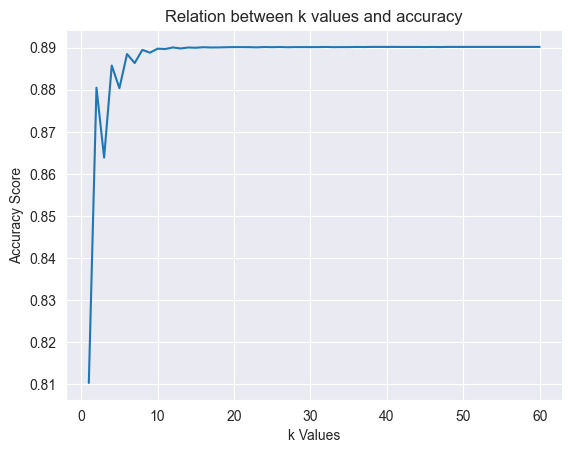

KNN cross-validation - average accuracy: 0.8878145984278415
KNN cross-validation - best k: 38
Shape of training dataset after imputation: (81437, 45)
Shape of test dataset after imputation: (20329, 45)
Total missing values in training dataset after imputation: 0
Total missing values in test dataset after imputation: 0
First 20 Rows of the Imputed Training Dataset:


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[50-60),3.0,1.0,1.0,2.0,MC,Surgery-Neuro,49.0,...,No,No,No,No,No,No,No,No,No,0.0
1,Caucasian,Female,[80-90),1.0,3.0,7.0,4.0,MC,InternalMedicine,68.0,...,No,No,No,No,No,No,No,No,Yes,0.0
2,Caucasian,Female,[80-90),1.0,1.0,7.0,3.0,MC,InternalMedicine,46.0,...,No,No,No,No,No,No,No,Ch,Yes,0.0
3,AfricanAmerican,Female,[30-40),1.0,1.0,7.0,5.0,MC,InternalMedicine,49.0,...,No,No,No,No,No,No,No,No,Yes,0.0
4,Caucasian,Female,[60-70),3.0,1.0,1.0,9.0,MC,InternalMedicine,52.0,...,No,Steady,No,No,No,No,No,No,Yes,0.0
5,Caucasian,Male,[70-80),3.0,6.0,4.0,14.0,MC,InternalMedicine,21.0,...,No,Steady,No,No,No,No,No,No,Yes,0.0
6,Caucasian,Female,[70-80),2.0,3.0,1.0,12.0,MC,InternalMedicine,47.0,...,No,Steady,No,No,No,No,No,Ch,Yes,0.0
7,Caucasian,Male,[60-70),2.0,1.0,1.0,8.0,MC,Cardiology,57.0,...,No,Steady,No,No,No,No,No,No,Yes,0.0
8,Caucasian,Female,[70-80),3.0,1.0,1.0,1.0,MC,Orthopedics-Reconstructive,31.0,...,No,No,No,No,No,No,No,No,No,0.0
9,Caucasian,Female,[80-90),1.0,3.0,7.0,7.0,MC,InternalMedicine,77.0,...,No,Steady,No,No,No,No,No,No,Yes,0.0


In [33]:
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

categorical_columns = data_impute.select_dtypes(include=['object', 'category']).columns
numerical_columns = data_impute.select_dtypes(include=['number']).columns

# Handling missing values in categorical features using Simple Imputer with "most frequent" strategy
categorical_imputer = SimpleImputer(strategy='most_frequent')
data_impute[categorical_columns] = categorical_imputer.fit_transform(data_impute[categorical_columns])
test_data_impute[categorical_columns] = categorical_imputer.transform(test_data_impute[categorical_columns])

# Handling missing values in numerical features using KNN Imputer with the given k value
k = tune_knn_imputer(data_impute.copy()) # best k is chosen using hyperparameter tuning with 5-folds cross validation
numerical_imputer = KNNImputer(n_neighbors=k)
data_impute[numerical_columns] = numerical_imputer.fit_transform(data_impute[numerical_columns])
test_data_impute[numerical_columns] = numerical_imputer.transform(test_data_impute[numerical_columns])

print("Shape of training dataset after imputation:", data_impute.shape)
print("Shape of test dataset after imputation:", test_data_impute.shape)
print("Total missing values in training dataset after imputation:", data_impute.isnull().sum().sum())
print("Total missing values in test dataset after imputation:", test_data_impute.isnull().sum().sum())

print("First 20 Rows of the Imputed Training Dataset:")
data_impute.head(10)

In [34]:
print("First 20 Rows of the Imputed Test Dataset:")
test_data_impute.head(10)

First 20 Rows of the Imputed Test Dataset:


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Male,[90-100),1.0,1.0,7.0,2.0,MC,InternalMedicine,20.0,...,No,Steady,No,No,No,No,No,Ch,Yes,0.0
1,Caucasian,Female,[60-70),1.0,6.0,7.0,2.0,BC,InternalMedicine,61.0,...,No,Up,No,No,No,No,No,Ch,Yes,1.0
2,Caucasian,Female,[40-50),2.0,1.0,1.0,3.0,HM,InternalMedicine,54.0,...,No,No,No,No,No,No,No,No,No,0.0
3,Caucasian,Male,[70-80),2.0,6.0,1.0,3.0,MC,PhysicalMedicineandRehabilitation,2.0,...,No,No,No,No,No,No,No,No,Yes,0.0
4,Caucasian,Female,[50-60),2.0,1.0,7.0,13.0,HM,Pulmonology,65.0,...,No,Steady,No,No,No,No,No,No,Yes,0.0
5,Caucasian,Female,[40-50),1.0,1.0,7.0,2.0,PO,InternalMedicine,9.0,...,No,Steady,No,No,No,No,No,No,Yes,0.0
6,Caucasian,Female,[70-80),3.0,1.0,7.0,3.0,MC,Emergency/Trauma,1.0,...,No,Steady,No,No,No,No,No,Ch,Yes,0.0
7,Caucasian,Male,[30-40),1.0,1.0,7.0,2.0,MD,Emergency/Trauma,58.0,...,No,Up,No,No,No,No,No,Ch,Yes,0.0
8,Caucasian,Female,[60-70),6.0,1.0,17.0,2.0,MC,Surgery-General,3.0,...,No,Steady,No,No,No,No,No,No,Yes,0.0
9,Caucasian,Male,[70-80),1.0,1.0,7.0,5.0,MC,Emergency/Trauma,63.0,...,No,Steady,No,No,No,No,No,Ch,Yes,0.0


### One-Hot Encoding

Encode non-numerical features in the dataset.

In [35]:
from sklearn.preprocessing import OneHotEncoder

data_onehot = data_impute.copy() # Training dataset used for all the preprocessing

# this is already done above
# data_onehot['binary'] = data_onehot['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
# data_onehot.drop(['readmitted'], axis=1, inplace=True)

categorical_features = data_onehot.select_dtypes(include=['object', 'category']).columns
numerical_features = data_onehot.select_dtypes(include=['number']).columns

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(data_onehot[categorical_features])

encoded_train = encoder.transform(data_onehot[categorical_features])
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_features))

encoded_test = encoder.transform(test_data_impute[categorical_features])
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_features))

data_onehot = pd.concat([data_onehot.reset_index(drop=True).drop(columns=categorical_features), encoded_train_df], axis=1)
test_onehot = pd.concat([test_data_impute.reset_index(drop=True).drop(columns=categorical_features), encoded_test_df], axis=1)

print(f"Training Dataset Shape Before Encoding: {data_impute.shape}")
print(f"Training Dataset Shape After Encoding: {data_onehot.shape}")
print(data_onehot.head())

print(f"Test Dataset Shape Before Encoding: {test_data_impute.shape}")
print(f"Test Dataset Shape After Encoding: {test_onehot.shape}")
print(test_onehot.head())

Training Dataset Shape Before Encoding: (81437, 45)
Training Dataset Shape After Encoding: (81437, 2355)
   admission_type_id  discharge_disposition_id  admission_source_id  \
0                3.0                       1.0                  1.0   
1                1.0                       3.0                  7.0   
2                1.0                       1.0                  7.0   
3                1.0                       1.0                  7.0   
4                3.0                       1.0                  1.0   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0               2.0                49.0             1.0             11.0   
1               4.0                68.0             2.0             23.0   
2               3.0                46.0             0.0             20.0   
3               5.0                49.0             0.0              5.0   
4               9.0                52.0             1.0             16.0   

   number_o

Observation about One-Hot Encoding

One-hot encoding increases the number of features drastically, from 45 features to 2356 features. Hence, it is not selected as the encoding method due to its inefficiency in feature reduction.

#### Label Encoding 

Use sklearn's label encoder to convert the categorical columns into numeric.

In [36]:
from sklearn import preprocessing

# Apply mapping to non-numeric columns
mapped_data = data_impute.copy() # Training data
test_mapped_data = test_data_impute.copy() # Test data

categorical_cols = dataset.select_dtypes(include=['object', 'category']).columns
print(f"There are {len(categorical_cols)} categorical columns.")

for column in categorical_cols:
    label_encoder = preprocessing.LabelEncoder()
    trained_le = label_encoder.fit(dataset[column]) # Using the original dataset to correctly encapture all unique categorical values 
    mapped_data[column] = trained_le.transform(mapped_data[column])
    test_mapped_data[column] = trained_le.transform(test_mapped_data[column])

mapped_data.head(20)

There are 33 categorical columns.


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,3,0,5,3.0,1.0,1.0,2.0,8,65,49.0,...,0,1,1,0,0,0,0,1,0,0.0
1,3,0,8,1.0,3.0,7.0,4.0,8,19,68.0,...,0,1,1,0,0,0,0,1,1,0.0
2,3,0,8,1.0,1.0,7.0,3.0,8,19,46.0,...,0,1,1,0,0,0,0,0,1,0.0
3,1,0,3,1.0,1.0,7.0,5.0,8,19,49.0,...,0,1,1,0,0,0,0,1,1,0.0
4,3,0,6,3.0,1.0,1.0,9.0,8,19,52.0,...,0,2,1,0,0,0,0,1,1,0.0
5,3,1,7,3.0,6.0,4.0,14.0,8,19,21.0,...,0,2,1,0,0,0,0,1,1,0.0
6,3,0,7,2.0,3.0,1.0,12.0,8,19,47.0,...,0,2,1,0,0,0,0,0,1,0.0
7,3,1,6,2.0,1.0,1.0,8.0,8,4,57.0,...,0,2,1,0,0,0,0,1,1,0.0
8,3,0,7,3.0,1.0,1.0,1.0,8,29,31.0,...,0,1,1,0,0,0,0,1,0,0.0
9,3,0,8,1.0,3.0,7.0,7.0,8,19,77.0,...,0,2,1,0,0,0,0,1,1,0.0


In [37]:
test_mapped_data.head(20)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,3,1,9,1.0,1.0,7.0,2.0,8,19,20.0,...,0,2,1,0,0,0,0,0,1,0.0
1,3,0,6,1.0,6.0,7.0,2.0,1,19,61.0,...,0,3,1,0,0,0,0,0,1,1.0
2,3,0,4,2.0,1.0,1.0,3.0,7,19,54.0,...,0,1,1,0,0,0,0,1,0,0.0
3,3,1,7,2.0,6.0,1.0,3.0,8,44,2.0,...,0,1,1,0,0,0,0,1,1,0.0
4,3,0,5,2.0,1.0,7.0,13.0,7,52,65.0,...,0,2,1,0,0,0,0,1,1,0.0
5,3,0,4,1.0,1.0,7.0,2.0,13,19,9.0,...,0,2,1,0,0,0,0,1,1,0.0
6,3,0,7,3.0,1.0,7.0,3.0,8,9,1.0,...,0,2,1,0,0,0,0,0,1,0.0
7,3,1,3,1.0,1.0,7.0,2.0,9,9,58.0,...,0,3,1,0,0,0,0,0,1,0.0
8,3,0,6,6.0,1.0,17.0,2.0,8,63,3.0,...,0,2,1,0,0,0,0,1,1,0.0
9,3,1,7,1.0,1.0,7.0,5.0,8,9,63.0,...,0,2,1,0,0,0,0,0,1,0.0


### Scaling (Standard Normalization)

In [38]:
# Scaling
X_train_mapped_data = mapped_data.drop(columns=['readmitted'])
X_test_mapped_data = test_mapped_data.drop(columns=['readmitted'])

og_train_means = X_train_mapped_data.mean(axis=0)
og_train_stds = X_train_mapped_data.std(axis=0)
print("Before Normalization - Training Set Mean:", og_train_means.mean())
print("Before Normalization - Training Set Std:", og_train_stds.mean())

og_test_means = X_test_mapped_data.mean(axis=0)
og_test_stds = X_test_mapped_data.std(axis=0)
print("Before Normalization - Test Set Mean:", og_test_means.mean())
print("Before Normalization - Test Set Std:", og_test_stds.mean())

scaler = StandardScaler()
scaler.fit(X_train_mapped_data)  # Fit on training data only
X_train_mapped_data = pd.DataFrame(scaler.transform(X_train_mapped_data), columns=X_train_mapped_data.columns)
X_test_mapped_data = pd.DataFrame(scaler.transform(X_test_mapped_data), columns=X_test_mapped_data.columns)

normalized_train_means = X_train_mapped_data.mean(axis=0)
normalized_train_stds = X_train_mapped_data.std(axis=0)
print("After Normalization - Training Set Mean:", normalized_train_means.mean())
print("After Normalization - Training Set Std:", normalized_train_stds.mean())

normalized_test_means = X_test_mapped_data.mean(axis=0)
normalized_test_stds = X_test_mapped_data.std(axis=0)
print("After Normalization - Test Set Mean:", normalized_test_means.mean())
print("After Normalization - Test Set Std:", normalized_test_stds.mean())

for column in X_train_mapped_data.columns:
    mapped_data[column] = X_train_mapped_data[column]
    test_mapped_data[column] = X_test_mapped_data[column]

Before Normalization - Training Set Mean: 23.32320661705032
Before Normalization - Training Set Std: 12.747093503279775
Before Normalization - Test Set Mean: 23.753683720971825
Before Normalization - Test Set Std: 12.787021435198566
After Normalization - Training Set Mean: -1.4862347036029948e-17
After Normalization - Training Set Std: 0.9545513152368208
After Normalization - Test Set Mean: 0.019750008589359606
After Normalization - Test Set Std: 0.9066287068040947


### Dimensionality Reduction Approaches

#### 1. Feature Selection

#### 1.1 Variance Threshold-based Approach

In [39]:
from sklearn.feature_selection import VarianceThreshold

X_train_mapped = mapped_data.drop(columns=['readmitted'])

selector = VarianceThreshold(threshold=0)

selector.fit(X_train_mapped)
selector.get_support()

cols = [column for column in X_train_mapped.columns
          if column not in X_train_mapped.columns[selector.get_support()]]

print("Columns removed due to having 0 variance:")
print(cols)

print("Shape of training dataset before dropping 0 variance columns:", mapped_data.shape)
print("Shape of test dataset before dropping 0 variance columns::", test_mapped_data.shape)

mapped_data.drop(cols, axis=1, inplace=True)
test_mapped_data.drop(cols, axis=1, inplace=True)

print("Shape of training dataset after dropping 0 variance columns:", mapped_data.shape)
print("Shape of test dataset after dropping 0 variance columns::", test_mapped_data.shape)

Columns removed due to having 0 variance:
['examide', 'citoglipton']
Shape of training dataset before dropping 0 variance columns: (81437, 45)
Shape of test dataset before dropping 0 variance columns:: (20329, 45)
Shape of training dataset after dropping 0 variance columns: (81437, 43)
Shape of test dataset after dropping 0 variance columns:: (20329, 43)


#### 1.2 Correlation-based Approach

In [40]:
# Computing the correlation matrix on the mapped training dataset
corr_matrix_mapped = mapped_data.corr()
print("Correlation Matrix for Mapped Data:")
print(corr_matrix_mapped)

Correlation Matrix for Mapped Data:
                              race    gender       age  admission_type_id  \
race                      1.000000  0.070956  0.132794           0.114323   
gender                    0.070956  1.000000 -0.041813           0.017514   
age                       0.132794 -0.041813  1.000000          -0.006832   
admission_type_id         0.114323  0.017514 -0.006832           1.000000   
discharge_disposition_id -0.002304 -0.017595  0.111464           0.102419   
admission_source_id       0.026045 -0.004770  0.051597           0.127221   
time_in_hospital         -0.020704 -0.029130  0.108617          -0.018705   
payer_code                0.031123  0.006454 -0.000137           0.007731   
medical_specialty        -0.004514  0.021218 -0.053385           0.125129   
num_lab_procedures       -0.024459 -0.002206  0.017436          -0.172154   
num_procedures            0.031373  0.062840 -0.027518           0.125136   
num_medications           0.036905 -0.02

In [41]:
compute_high_correlations(correlation_threshold=0.6, corr_matrix=corr_matrix_mapped)
compute_high_correlations(correlation_threshold=0.5, corr_matrix=corr_matrix_mapped)


Highly Correlated Features (Threshold > 0.6):
Empty DataFrame
Columns: []
Index: []

Highly Correlated Features (Threshold > 0.5):
               change  diabetesMed
change            NaN    -0.501872
diabetesMed -0.501872          NaN


**Observation:**

The highest correlation among the features is 0.5 in absolute value. Since 0.5 is not considered a high correlation, implementing a correlation-based feature reduction technique on the imputated data does not seem plausible.

Alternative method:

In [42]:
def remove_high_corr_features(data_set, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_mtrx = data_set.corr()
    # pd.DataFrame(data={'c0': [1, 2, 3], 'c1': [4, 5, 6], 'c2': [7, 8, 9]})

    for i in range(1, len(corr_mtrx.columns)):
        for j in range(0, i):
            # print("(", i, ", ", j, "):", corr_mtrx.iloc[i, j])
            # print(corr_mtrx.columns[j])

            if (abs(corr_mtrx.iloc[i, j]) >= threshold) and (corr_mtrx.columns[j] not in col_corr):
                col_name = corr_mtrx.columns[j] # getting the name of column
                col_corr.add(col_name)
                # print(col_corr) # -> columns that are removed due to having above the threshold absolute correlation

                if col_name in data_set.columns:
                    data_set.drop(columns=col_name, inplace=True)
                    # print(data_set)
                    # print(corr_mtrx) # -> dataset's correlation matrix

    print("Deleted", len(col_corr), "columns with threshold", threshold)
    print(col_corr)

In [43]:
X_train_mapped = mapped_data.drop(columns=['readmitted'])

remove_high_corr_features(X_train_mapped, 0.6)

Deleted 0 columns with threshold 0.6
set()


#### 1.3 Forward Selection (Wrapper Approach)

In [44]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression

# Use mapped_data and test_mapped_data datasets
# The current number of features is 43!

X_train = mapped_data.drop(columns=['readmitted'])
y_train = mapped_data['readmitted']

X_test = test_mapped_data.drop(columns=['readmitted'])
y_test = test_mapped_data['readmitted']

def forward_selection(X_train, y_train):

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Testing the possible values for k_features 
    # For forward feature selection
    k_features = [5, 8, 12, 15, 18, 20]

    forward_best_k = 0
    forward_best_val_score = 0
    forward_selected_features = []

    for k in k_features:
        clf = LogisticRegression(max_iter=500)
        ffs = sfs(clf, k_features=k, forward=True, floating=False, verbose=0, scoring='recall', cv=5) # 5-fold cross validation 

        ffs.fit(X_train, y_train)
        selected_features = list(ffs.k_feature_names_)  # Selected features
        print(f"Selected {k} features: {selected_features}")

        # Use selected features to fit a logistic classifier and evaluate on validation set
        clf.fit(X_train[selected_features], y_train)
        val_score = clf.score(X_val[selected_features], y_val)  
        
        print(f"Validation score for {k} features: {val_score}")

        if val_score > forward_best_val_score:
            forward_best_k = k
            forward_best_val_score = val_score
            forward_selected_features = selected_features

    print(f"\nBest number of features: {forward_best_k} with Validation score: {forward_best_val_score}")

forward_selection(X_train, y_train)

Selected 5 features: ['admission_source_id', 'number_inpatient', 'number_diagnoses', 'nateglinide', 'chlorpropamide']
Validation score for 5 features: 0.8851915520628684
Selected 8 features: ['admission_source_id', 'number_inpatient', 'number_diagnoses', 'nateglinide', 'chlorpropamide', 'acetohexamide', 'glyburide', 'tolbutamide']
Validation score for 8 features: 0.8851915520628684
Selected 12 features: ['admission_source_id', 'number_inpatient', 'number_diagnoses', 'nateglinide', 'chlorpropamide', 'acetohexamide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol']
Validation score for 12 features: 0.8851301571709234
Selected 15 features: ['admission_source_id', 'number_inpatient', 'number_diagnoses', 'nateglinide', 'chlorpropamide', 'acetohexamide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'glyburide-metformin']
Validation score for 15 features: 0.8851915520628684
Selected 18 fe

#### 1.4 Backward Selection

In [45]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LogisticRegression

# Use mapped_data and test_mapped_data datasets
# The current number of features is 43!

X_train = mapped_data.drop(columns=['readmitted'])
y_train = mapped_data['readmitted']

X_test = test_mapped_data.drop(columns=['readmitted'])
y_test = test_mapped_data['readmitted']

def backward_selection(X_train, y_train):

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Testing the possible values for k_features 
    # For forward feature selection
    k_features = [38, 35, 32, 30, 28, 25, 22]

    backward_best_k = 0
    backward_best_val_score = 0 
    backward_selected_features = []

    for k in k_features:
        clf = LogisticRegression(max_iter=500)

        # For backward selection, use forward=False
        ffs = sfs(clf, k_features=k, forward=False, floating=False, verbose=0, scoring='recall', cv=5) # 5-fold cross validation 

        ffs.fit(X_train, y_train)
        selected_features = list(ffs.k_feature_names_)  # Selected features
        print(f"Selected {k} features: {selected_features}")

        # Use selected features to fit a logistic classifier and evaluate on validation set
        clf.fit(X_train[selected_features], y_train)
        val_score = clf.score(X_val[selected_features], y_val)  
        
        print(f"Validation score for {k} features: {val_score}")

        if val_score > backward_best_val_score:
            backward_best_k = k
            backward_best_val_score = val_score
            backward_selected_features = selected_features

    print(f"\nBest number of features: {backward_best_k} with Validation score: {backward_best_val_score}")

backward_selection(X_train, y_train)

Selected 38 features: ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_2', 'diag_3', 'number_diagnoses', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']
Validation score for 38 features: 0.8851915520628684
Selected 35 features: ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatien

Observation about Feature Selection Approaches:

The accuracies for all subsets of features, for both forward and backward selections, are very close to each other, varying by only 0.0001 across all approaches tried.

#### 2. Feature Extraction

#### 2.1 Principal Component Analysis (PCA)

In [46]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train = mapped_data.drop(columns=['readmitted'])
y_train = mapped_data['readmitted']

X_test = test_mapped_data.drop(columns=['readmitted'])
y_test = test_mapped_data['readmitted']

original_columns = X_train.columns

# Scikit-learn chooses the minimum number of principal components such that 95 percent of the variance is retained
pca = PCA(.95)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

n_components = pca.n_components_
print(f"Number of principal components used: {n_components}")

explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by each principal component: {explained_variance}")

print("Classification Report Before PCA:")
lreg = LogisticRegression(max_iter=500)
lreg.fit(X_train, y_train)
y_pred = lreg.predict(X_test)
print(classification_report(y_test, y_pred))

print("Classification Report After PCA:")
lreg = LogisticRegression(max_iter=500)
lreg.fit(X_train_pca, y_train)
y_pred_pca = lreg.predict(X_test_pca)
print(classification_report(y_test, y_pred_pca))

components = pd.DataFrame(pca.components_, columns=original_columns)
important_features_pca = components.abs().idxmax(axis=1)

unique_important_features_pca = important_features_pca.unique()
print(f"Total number of unique important features: {len(unique_important_features_pca)}")
print("Unique important features:", unique_important_features_pca)

Number of principal components used: 38
Variance explained by each principal component: [0.05616936 0.0453085  0.03641854 0.03353741 0.0313174  0.02801964
 0.02734147 0.02577482 0.02568073 0.02524082 0.02495704 0.02460786
 0.02423997 0.02410108 0.02401178 0.02389369 0.02386324 0.02382985
 0.02381189 0.02380457 0.02380168 0.02370672 0.02366379 0.02351797
 0.02325212 0.02310451 0.0230119  0.02232929 0.02201223 0.02199539
 0.02082554 0.02054545 0.02018489 0.01951844 0.01808958 0.01735106
 0.01546087 0.01429899]
Classification Report Before PCA:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     18006
         1.0       0.34      0.01      0.01      2323

    accuracy                           0.89     20329
   macro avg       0.61      0.50      0.48     20329
weighted avg       0.82      0.89      0.83     20329

Classification Report After PCA:
              precision    recall  f1-score   support

         0.0       0.89      1.00    

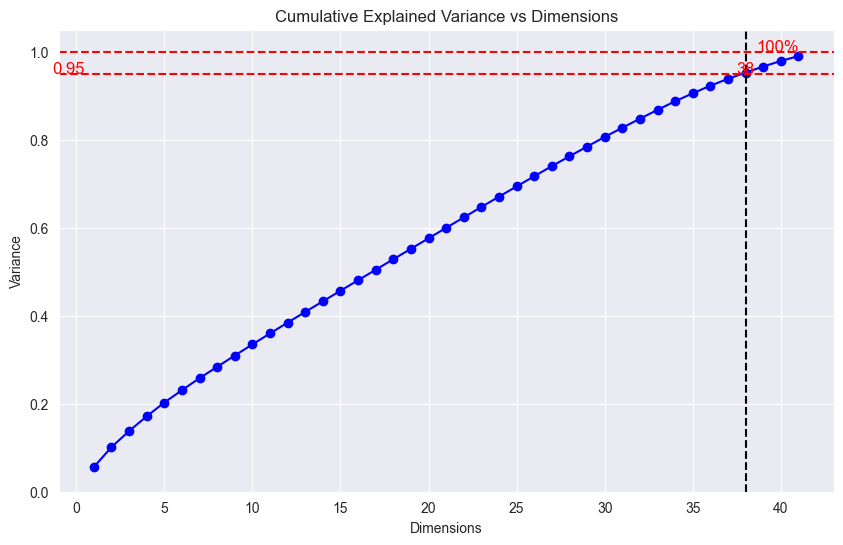

In [47]:
pca = PCA(.99)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Get the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components for 0.95 and 0.99 variance
dimensions_95 = np.argmax(cumulative_variance >= 0.95) + 1
dimensions_99 = np.argmax(cumulative_variance >= 0.99) + 1

# Plot the cumulative variance vs dimensions
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='b')

# Add dotted lines for the 0.95 and 1.0 variance marks
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.axvline(x=dimensions_95, color='k', linestyle='--')

# Highlighting the 0.95 point
plt.text(dimensions_95, 0.95, f'{dimensions_95}', color='red', fontsize=12, ha='center')
plt.text(0.5, 0.95, '0.95', color='red', fontsize=12, ha='right')

# Highlighting the 1.0 point
plt.text(len(cumulative_variance), 1.0, '100%', color='red', fontsize=12, ha='right')

# Add labels and title
plt.xlabel('Dimensions')
plt.ylabel('Variance')
plt.title('Cumulative Explained Variance vs Dimensions')
plt.ylim([0, 1.05])
plt.grid(True)

plt.show()

#### Choosen Feature Reduction Approach: PCA

The reason we chose PCA over selection techniques was that, for selection, we tried a range of k feature values but faced two main issues. Firstly, we couldn’t evaluate all 43 values due to computational inefficiency, as it didn’t return a result in a convenient amount of time.

Secondly, the results for different feature sets were very close to each other, possibly due to the severe imbalance in the dataset. To test the effect of imbalance on feature selection, we would first need to choose an imbalance-handling technique. However, this complicates the testing of the impact of imbalance-handling techniques due to the lack of feature reduction initially. Hence, we realized a loop between testing feature selection and imbalance-handling techniques, as each required the other component.

Since the core aspect of our comparative study is to address class imbalance, we decided to stick to PCA as the feature reduction technique to effectively test the impact of class imbalance approaches on the accuracy of the classifiers.

In [48]:
# The transformed data by PCA will be used for classification
X_train = X_train_pca.copy()
y_train = mapped_data['readmitted']

X_test = X_test_pca.copy()
y_test = test_mapped_data['readmitted']

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(81437, 41)
(20329, 41)
(81437,)
(20329,)


### Imbalance Handling 

#### SMOTE

In [49]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print('Original Class Distribution:', Counter(y_train))
print('Over-sampled Class Distribution:', Counter(y_resampled))

# Important Note: The test dataset should reflect the actual class distribution in the population, although it is imbalanced.
# Hence, we don't implement SMOTE technique on the test dataset.

Original Class Distribution: Counter({0.0: 72403, 1.0: 9034})
Over-sampled Class Distribution: Counter({0.0: 72403, 1.0: 72403})


Classes are now balanced using the SMOTE technique.

#### Undersampling

In [50]:
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=42)

X_under, y_under = under_sampler.fit_resample(X_train, y_train)

print('Original Class Distribution:', Counter(y_train))
print('Under-sampled Class Distribution:', Counter(y_under))

Original Class Distribution: Counter({0.0: 72403, 1.0: 9034})
Under-sampled Class Distribution: Counter({0.0: 9034, 1.0: 9034})


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('\nPerformance on Original Data:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix (Original Data):\n', confusion_matrix(y_test, y_pred))

# Implement balanced class weights
# with the parameter class_weight = "balanced"
model_original = LogisticRegression(random_state=42, class_weight='balanced', max_iter=500)
model_original.fit(X_train, y_train)
y_pred_original = model_original.predict(X_test)

print('\nPerformance on Original Data with Balanced Class Weights:')
print(classification_report(y_test, y_pred_original))
print('Confusion Matrix (Original Data) with Balanced Class Weights:\n', confusion_matrix(y_test, y_pred_original))

model_smote = LogisticRegression(random_state=42, max_iter=500)
model_smote.fit(X_resampled, y_resampled)
y_pred_smote = model_smote.predict(X_test)

print('\nPerformance on SMOTE-Resampled Data:')
print(classification_report(y_test, y_pred_smote))
print('Confusion Matrix (SMOTE Data):\n', confusion_matrix(y_test, y_pred_smote))

model_under = LogisticRegression(random_state=42, max_iter=500)
model_under.fit(X_under, y_under)
y_pred_under = model_under.predict(X_test)

print('\nPerformance on Under-sampled Data:')
print(classification_report(y_test, y_pred_under))
print('Confusion Matrix (Under-sampled Data):\n', confusion_matrix(y_test, y_pred_under))

model_original.get_params()


Performance on Original Data:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     18006
         1.0       0.34      0.01      0.01      2323

    accuracy                           0.89     20329
   macro avg       0.61      0.50      0.48     20329
weighted avg       0.82      0.89      0.83     20329

Confusion Matrix (Original Data):
 [[17981    25]
 [ 2310    13]]

Performance on Original Data with Balanced Class Weights:
              precision    recall  f1-score   support

         0.0       0.91      0.68      0.78     18006
         1.0       0.17      0.50      0.25      2323

    accuracy                           0.66     20329
   macro avg       0.54      0.59      0.51     20329
weighted avg       0.83      0.66      0.72     20329

Confusion Matrix (Original Data) with Balanced Class Weights:
 [[12188  5818]
 [ 1169  1154]]

Performance on SMOTE-Resampled Data:
              precision    recall  f1-score   support

   

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Balanced class weights, undersampling, and oversampling techniques all yield similar results.

**More observations about the results:**

Notice that with imbalance handling we have higher recall but lower precision on the minority class, which is what we want. When dealing with this kind of healthy - sick classification, we should focus more on correctly classifying really sick people, even with the trade-off of a high FP rate.

Note that recall measures the true positive rate. Obtaining a higher recall means that our model is now better at identifying patients with early admission, which is crucial because we don't want to miss a positive case as it could have significant consequences.

Precision measures the proportion of predicted positives that are actually positive. A lower precision means that a larger number of false positives are included in our predictions.

But for the purpose of our classification, we expected this tradeoff. For our purpose, having a higher positive rate (higher recall) is much more crucial.

### Logistic Regression with Hyperparameter Tuning

In [52]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log_loss', random_state=42, max_iter=500, class_weight='balanced')
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.predict(X_test)

print('\nPerformance on SGD with Balanced Class Weights:')
print(classification_report(y_test, y_pred_sgd))
print('Confusion Matrix (Original Data & SGD) with Balanced Class Weights:\n', confusion_matrix(y_test, y_pred_sgd))


Performance on SGD with Balanced Class Weights:
              precision    recall  f1-score   support

         0.0       0.91      0.67      0.77     18006
         1.0       0.15      0.47      0.23      2323

    accuracy                           0.64     20329
   macro avg       0.53      0.57      0.50     20329
weighted avg       0.82      0.64      0.71     20329

Confusion Matrix (Original Data & SGD) with Balanced Class Weights:
 [[11994  6012]
 [ 1238  1085]]


In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10],
              'penalty': ['l1', 'l2'],
              'solver': ['newton-cholesky', 'saga', 'lbfgs']
              }

logreg = LogisticRegression(max_iter=500, random_state=42, class_weight='balanced')
grid_search_log = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1)
grid_search_log.fit(X_train, y_train)

print('Best Parameters:', grid_search_log.best_params_)
print('Best F1:', grid_search_log.best_score_)

best_logreg = grid_search_log.best_estimator_
y_pred_logreg = best_logreg.predict(X_test)
print('\nPerformance on Logreg with tuning:')
print(classification_report(y_test, y_pred_logreg))
print('Confusion Matrix with Logreg with tuning:\n', confusion_matrix(y_test, y_pred_logreg))

C:\Users\madap\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\madap\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\madap\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\madap\AppDa

Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Best F1: 0.4349062125204002

Performance on Logreg with tuning:
              precision    recall  f1-score   support

         0.0       0.91      0.68      0.78     18006
         1.0       0.17      0.50      0.25      2323

    accuracy                           0.66     20329
   macro avg       0.54      0.59      0.51     20329
weighted avg       0.83      0.66      0.72     20329

Confusion Matrix with Logreg with tuning:
 [[12217  5789]
 [ 1172  1151]]


### KNN Classifier with Hyperparameter Tuning

In [56]:
import statistics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

def get_best_k(train_x, train_y):
	k_values = [x for x in range(1, 61)]
	scores = []
	counter = 1
	for k_val in k_values:
		knn = KNeighborsClassifier(n_neighbors=k_val)
		score = cross_val_score(knn, train_x, train_y, scoring="recall", cv=5)
		scores.append(np.mean(score))
		print(f"Iteration {counter}: Cross-Validation Score = {score}, k = {k_val}")
		counter += 1

	# see relation between k values and accuracy
	plt.plot(k_values, scores)
	plt.xlabel("k Values")
	plt.ylabel("Recall Score")
	plt.title("Relation between k values and recall")
	plt.legend(['Original Data', 'Over Sampled Data', 'Under Sampled Data'])
	print("Average Recall:", statistics.mean(scores))

	# choose the k value that maximizes accuracy
	best_index = np.argmax(scores)
	best_k = k_values[best_index]
	print("The best k:", best_k)

	return best_k

def train_knn(train_x, train_y, test_x, test_y):
	knn_clf = KNeighborsClassifier(n_neighbors=get_best_k(train_x, train_y))
	knn_clf.fit(train_x, train_y)

	train_y_pred = knn_clf.predict(train_x)
	print("KNN tuned - Train:")
	print(classification_report(train_y, train_y_pred))
	print('Confusion Matrix (Train):\n', confusion_matrix(train_y, train_y_pred))

	test_y_pred = knn_clf.predict(test_x)
	print("KNN tuned - Test:")
	print(classification_report(test_y, test_y_pred))
	print('Confusion Matrix (Test):\n', confusion_matrix(test_y, test_y_pred))

KNN with Original Data
Iteration 1: Cross-Validation Score = [0.11566132 0.0807969  0.07918051 0.11566132 0.17930271], k = 1
Iteration 2: Cross-Validation Score = [0.01438849 0.00940786 0.00885936 0.02102933 0.04648589], k = 2
Iteration 3: Cross-Validation Score = [0.04039845 0.02324294 0.03322259 0.05700055 0.10182623], k = 3
Iteration 4: Cross-Validation Score = [0.00664084 0.00664084 0.00996678 0.0154953  0.03707803], k = 4
Iteration 5: Cross-Validation Score = [0.01936912 0.01217488 0.01882614 0.02767017 0.06917543], k = 5
Iteration 6: Cross-Validation Score = [0.00553403 0.00387382 0.00609081 0.00940786 0.03597122], k = 6
Iteration 7: Cross-Validation Score = [0.01106807 0.00608744 0.00885936 0.0166021  0.05644715], k = 7
Iteration 8: Cross-Validation Score = [0.00608744 0.00332042 0.00442968 0.00830105 0.0320974 ], k = 8
Iteration 9: Cross-Validation Score = [0.00719424 0.00553403 0.00719823 0.01494189 0.04925291], k = 9
Iteration 10: Cross-Validation Score = [0.00442723 0.003320

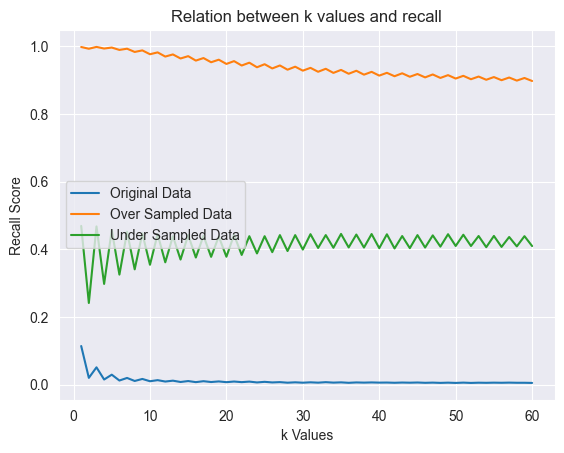

In [59]:
# KNN with Original dataset
knn_X_train = X_train_pca.copy()
knn_y_train = mapped_data['readmitted']
print("KNN with Original Data")
train_knn(knn_X_train, knn_y_train, X_test, y_test)

# KNN with Over-sampled data
X_train_over = X_resampled
y_train_over = y_resampled
print("KNN with Over Sampled Data")
train_knn(X_train_over, y_train_over, X_test, y_test)

# KNN with Under-sampled data
X_train_under = X_under
y_train_under = y_under
print("KNN with Under Sampled Data")
train_knn(X_train_under, y_train_under, X_test, y_test)

### SVM Classifier with Hyperparameter Tuning

In [92]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

def svm_get_best_parameters_grid_search(X_train_svm, y_train_svm):
    """
    Finds the best parameters for SVM using Grid Search
    """
    #svm_clf.get_params()
    inner_cv = KFold(n_splits=3, random_state=0, shuffle=True)
    #outer_cv = KFold(n_splits=5, random_state=0, shuffle=True)
    svm_grid = {"C": [0.1, 1, 10],
                "kernel": ["poly", "rbf"],
                "gamma": [0.01, 0.1, "scale"]
                }

    svm = SVC(random_state=0)
    svm_grid_clf = GridSearchCV(estimator=svm, param_grid=svm_grid, scoring="recall", cv=inner_cv)

    # nested_scores = cross_val_score(svm_grid_clf, X=svmX_train, y=svmY_train, cv=outer_cv, scoring='accuracy')
    # print("Nested Cross-Validation Scores:", nested_scores)
    # print("Average Nested CV Score:", nested_scores.mean())

    svm_grid_clf.fit(X_train_svm, y_train_svm)
    svm_best_params = svm_grid_clf.best_params_
    print("Best Parameters for SVM:", svm_best_params)

    svm_best_cv_score = svm_grid_clf.best_score_
    print("Best CV Score for SVM:", svm_best_cv_score)

    return svm_best_params


def svm_get_best_parameters_cv_score(X_train_svm, y_train_svm):
    """
    Implements a more efficienct approach for hyperparameter tuning
    using cross-validation scores
    """
    C_values = [0.1, 1, 10]
    gamma_values = [0.01, 0.1, "scale"]
    kernels = ["poly", "rbf"]

    scores = []
    svm_best_score = 0
    svm_best_params = {}

    counter = 1
    for kernel in kernels:
        for C in C_values:
            for gamma in gamma_values:
                # The below combination of parameter values do not return an answer,
                # so they are manually excluded from the hyperparameter tuning of SVM classifier
                if C == 10 and kernel == "poly" and gamma == 0.1:
                    continue
                svm = SVC(C=C, kernel=kernel, gamma=gamma, random_state=0)
                score = cross_val_score(svm, X_train_svm, y_train_svm, scoring="recall", cv=3).mean()
                scores.append((C, kernel, gamma, score))
                print(f"Iteration {counter}: Cross-Validation Score = {score}, C = {C}, Kernel = {kernel}, Gamma = {gamma}")
                counter += 1

                if score > svm_best_score:
                    svm_best_score = score
                    svm_best_params = {"C": C, "kernel": kernel, "gamma": gamma}

    print("Best Parameters for SVM:", svm_best_params)
    print("Best CV Score for SVM:", svm_best_score)
    return svm_best_params


def train_svm(train_x, train_y, test_x, test_y, best_params):
    svm_clf = SVC(**best_params)
    svm_clf.fit(train_x, train_y)

    train_y_pred = svm_clf.predict(train_x)
    print("SVM tuned - Train:")
    print(classification_report(train_y, train_y_pred))
    print('Confusion Matrix (Train):\n', confusion_matrix(train_y, train_y_pred))

    test_y_pred = svm_clf.predict(test_x)
    print("SVM tuned - Test:")
    print(classification_report(test_y, test_y_pred))
    print('Confusion Matrix (Test):\n', confusion_matrix(test_y, test_y_pred))

In [ ]:
# SVM with Original dataset
#svm_X_train = X_train_pca.copy()
#svm_y_train = mapped_data['readmitted']
#print("SVM with Original Data")
#svm_best_params = svm_get_best_parameters_cv_score(svm_X_train, svm_y_train)
#train_svm(svm_X_train, svm_y_train, X_test, y_test, svm_best_params)

# SVM with original dataset didn't return an answer for a very long time
# due to the size of the oversampled dataset.

SVM with Original Data


In [93]:
# SVM with Under-sampled data
print("SVM with Under-Sampled Data")
svm_X_train_under = X_under
svm_y_train_under = y_under
svm_best_params = svm_get_best_parameters_cv_score(svm_X_train_under, svm_y_train_under)
train_svm(svm_X_train_under, svm_y_train_under, X_test, y_test, svm_best_params)

SVM with Under-Sampled Data
Iteration 1: Cross-Validation Score = 0.02767376194325984, C = 0.1, Kernel = poly, Gamma = 0.01
Iteration 2: Cross-Validation Score = 0.4048007387403043, C = 0.1, Kernel = poly, Gamma = 0.1
Iteration 3: Cross-Validation Score = 0.17555590399022383, C = 0.1, Kernel = poly, Gamma = scale
Iteration 4: Cross-Validation Score = 0.1267414566245149, C = 1, Kernel = poly, Gamma = 0.01
Iteration 5: Cross-Validation Score = 0.431809828474581, C = 1, Kernel = poly, Gamma = 0.1
Iteration 6: Cross-Validation Score = 0.3436948173945055, C = 1, Kernel = poly, Gamma = scale
Iteration 7: Cross-Validation Score = 0.3225517061610747, C = 10, Kernel = poly, Gamma = 0.01
Iteration 8: Cross-Validation Score = 0.41487410261533303, C = 10, Kernel = poly, Gamma = scale
Iteration 9: Cross-Validation Score = 0.3856489977945703, C = 0.1, Kernel = rbf, Gamma = 0.01
Iteration 10: Cross-Validation Score = 0.5353118688756543, C = 0.1, Kernel = rbf, Gamma = 0.1
Iteration 11: Cross-Validatio

In [ ]:
# SVM with Over-sampled data
#print("SVM with Over-Sampled Data")
#svm_X_train_over = X_resampled
#svm_y_train_over = y_resampled
#train_svm(svm_X_train_over, svm_y_train_over, X_test, y_test, svm_best_params)

# Over-sampling didn't return an answer for a very long time with SVM classifier
# due to the size of the oversampled dataset.

We also tried some more advanced imbalance handling techniques:

### Bagging + SMOTE (SMOTEBagging)

In [94]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

param_grid_bagging = {'estimator__max_depth': [None, 3, 5, 10],
              'n_estimators': [10, 25, 50]
              }

smote_bagging = BalancedBaggingClassifier(
    estimator=DecisionTreeClassifier(),
    sampling_strategy='auto',
    replacement=False,
    random_state=42,
    #n_estimators=25,
    n_jobs=-1
)

grid_search_bagging = GridSearchCV(estimator=smote_bagging, param_grid=param_grid_bagging, scoring='recall', cv=5, n_jobs=-1)
grid_search_bagging.fit(X_train, y_train)
print("Best Parameters (Bagging):", grid_search_bagging.best_params_)

best_bagging = grid_search_bagging.best_estimator_
y_pred_bagging = best_bagging.predict(X_test)
print('\nPerformance on SMOTEBagging:')
print(classification_report(y_test, y_pred_bagging))
print('Confusion Matrix (SMOTEBagging):\n', confusion_matrix(y_test, y_pred_bagging))

#smote_bagging.get_params()

Best Parameters (Bagging): {'estimator__max_depth': 5, 'n_estimators': 50}

Performance on SMOTEBagging:
              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80     18006
         1.0       0.17      0.44      0.24      2323

    accuracy                           0.68     20329
   macro avg       0.54      0.58      0.52     20329
weighted avg       0.82      0.68      0.73     20329

Confusion Matrix (SMOTEBagging):
 [[12812  5194]
 [ 1293  1030]]


In [95]:
from sklearn.ensemble import RandomForestClassifier

smote_bagging_rf = BalancedBaggingClassifier(
    estimator=RandomForestClassifier(),
    sampling_strategy='auto',
    replacement=False,
    random_state=42,
    n_estimators=10,
    n_jobs=-1
)

smote_bagging_rf.fit(X_train, y_train)
y_pred_bagging_rf = smote_bagging_rf.predict(X_test)
print('\nPerformance on SMOTEBagging with Random Forest:')
print(classification_report(y_test, y_pred_bagging_rf))
print('Confusion Matrix (SMOTEBagging with Random Forest):\n', confusion_matrix(y_test, y_pred_bagging_rf))


Performance on SMOTEBagging with Random Forest:
              precision    recall  f1-score   support

         0.0       0.90      0.85      0.87     18006
         1.0       0.20      0.30      0.24      2323

    accuracy                           0.78     20329
   macro avg       0.55      0.57      0.56     20329
weighted avg       0.82      0.78      0.80     20329

Confusion Matrix (SMOTEBagging with Random Forest):
 [[15226  2780]
 [ 1623   700]]


### Boosting + Under-sampling (RUSBoost)

In [96]:
from imblearn.ensemble import RUSBoostClassifier

param_grid_boosting = {'estimator__max_depth': [None, 3, 5, 10],
              'n_estimators': [10, 25]
              }

rus_boost = RUSBoostClassifier(
    estimator=DecisionTreeClassifier(),
    sampling_strategy='auto',
    random_state=42,
    #n_estimators=25
)

grid_search_boosting = GridSearchCV(estimator=rus_boost, param_grid=param_grid_boosting, scoring='recall', cv=5, n_jobs=-1)
grid_search_boosting.fit(X_train, y_train)
print("Best Parameters (Boosting):", grid_search_boosting.best_params_)

best_boosting = grid_search_boosting.best_estimator_
y_pred_boosting = best_boosting.predict(X_test)
print('\nPerformance on RUSBoosting:')
print(classification_report(y_test, y_pred_boosting))
print('Confusion Matrix (RUSBoosting):\n', confusion_matrix(y_test, y_pred_boosting))

Best Parameters (Boosting): {'estimator__max_depth': None, 'n_estimators': 25}

Performance on RUSBoosting:
              precision    recall  f1-score   support

         0.0       0.91      0.50      0.65     18006
         1.0       0.14      0.63      0.23      2323

    accuracy                           0.52     20329
   macro avg       0.53      0.56      0.44     20329
weighted avg       0.82      0.52      0.60     20329

Confusion Matrix (RUSBoosting):
 [[9029 8977]
 [ 870 1453]]


In [97]:
rus_boost_rf = RUSBoostClassifier(
    estimator=RandomForestClassifier(),
    sampling_strategy='auto',
    random_state=42,
    n_estimators=10
)

rus_boost_rf.fit(X_train, y_train)
y_pred_boosting_rf = rus_boost_rf.predict(X_test)
print('\nPerformance on RUSBoosting with Random Forest:')
print(classification_report(y_test, y_pred_boosting_rf))
print('Confusion Matrix (RUSBoosting with Random Forest):\n', confusion_matrix(y_test, y_pred_boosting_rf))


Performance on RUSBoosting with Random Forest:
              precision    recall  f1-score   support

         0.0       0.91      0.61      0.73     18006
         1.0       0.15      0.55      0.24      2323

    accuracy                           0.60     20329
   macro avg       0.53      0.58      0.48     20329
weighted avg       0.83      0.60      0.67     20329

Confusion Matrix (RUSBoosting with Random Forest):
 [[10943  7063]
 [ 1054  1269]]


### Stacking

In [98]:
from imblearn.ensemble import EasyEnsembleClassifier

easy_ensemble = EasyEnsembleClassifier(random_state=42, n_estimators=20)

easy_ensemble.fit(X_train, y_train)
y_pred_ensemble = easy_ensemble.predict(X_test)
print('\nPerformance on EasyEnsemble:')
print(classification_report(y_test, y_pred_ensemble))
print('Confusion Matrix (EasyEnsemble):\n', confusion_matrix(y_test, y_pred_ensemble))


Performance on EasyEnsemble:
              precision    recall  f1-score   support

         0.0       0.91      0.66      0.77     18006
         1.0       0.16      0.49      0.24      2323

    accuracy                           0.64     20329
   macro avg       0.53      0.58      0.50     20329
weighted avg       0.82      0.64      0.71     20329

Confusion Matrix (EasyEnsemble):
 [[11923  6083]
 [ 1175  1148]]


In [99]:
"""
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

base_estimators = [
    ('lr', LogisticRegression(random_state=42, max_iter=500)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
]

stacking_classifier = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

stacking_classifier.fit(X_train, y_train)
y_pred_stacking = stacking_classifier.predict(X_test)
print('\nPerformance on Stacking:')
print(classification_report(y_test, y_pred_stacking))
print('Confusion Matrix (Stacking):\n', confusion_matrix(y_test, y_pred_stacking))
"""

"\nfrom sklearn.ensemble import StackingClassifier\nfrom sklearn.svm import SVC\n\nbase_estimators = [\n    ('lr', LogisticRegression(random_state=42, max_iter=500)),\n    ('rf', RandomForestClassifier(random_state=42)),\n    ('svm', SVC(probability=True, random_state=42))\n]\n\nstacking_classifier = StackingClassifier(\n    estimators=base_estimators,\n    final_estimator=LogisticRegression(),\n    n_jobs=-1\n)\n\nstacking_classifier.fit(X_train, y_train)\ny_pred_stacking = stacking_classifier.predict(X_test)\nprint('\nPerformance on Stacking:')\nprint(classification_report(y_test, y_pred_stacking))\nprint('Confusion Matrix (Stacking):\n', confusion_matrix(y_test, y_pred_stacking))\n"